# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></div><div class="lev1 toc-item"><a href="#Read-output-of-imcat-(final_text.txt)" data-toc-modified-id="Read-output-of-imcat-(final_text.txt)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read output of imcat (final_text.txt)</a></div><div class="lev1 toc-item"><a href="#Bin-the-magnitude-in-10-parts" data-toc-modified-id="Bin-the-magnitude-in-10-parts-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Bin the magnitude in 10 parts</a></div><div class="lev1 toc-item"><a href="#Bin-with-highest-rms-gmsq" data-toc-modified-id="Bin-with-highest-rms-gmsq-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bin with highest rms gmsq</a></div><div class="lev1 toc-item"><a href="#Galaxies-above-and-below-boundary-line-of-contour-plot" data-toc-modified-id="Galaxies-above-and-below-boundary-line-of-contour-plot-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Galaxies above and below boundary line of contour plot</a></div><div class="lev1 toc-item"><a href="#Redo-rms-gsmq-calculation-for-df_above" data-toc-modified-id="Redo-rms-gsmq-calculation-for-df_above-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Redo rms gsmq calculation for df_above</a></div><div class="lev1 toc-item"><a href="#Histograms-of-magnitude-bins" data-toc-modified-id="Histograms-of-magnitude-bins-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Histograms of magnitude bins</a></div><div class="lev1 toc-item"><a href="#Scatter-plot-of-x-vs-y-of-magnitude-bins" data-toc-modified-id="Scatter-plot-of-x-vs-y-of-magnitude-bins-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Scatter plot of x vs y of magnitude bins</a></div>

# Introduction
Date: Nov 27, 2019

**Most Recent Update**
Added cleancat to imcat script.

**Usual Filtering**  
```python
df = df.query('calib_psfCandidate == 0.0')
df = df.query('deblend_nChild == 0.0')
df['ellip'] = np.hypot( df['ext_shapeHSM_HsmShapeRegauss_e1'] ,
                        df['ext_shapeHSM_HsmShapeRegauss_e2'] )
df = df.query('ellip < 2.0') # it was 1.5 before

#select only few columns after filtering:
cols_select = ['base_SdssCentroid_x', 'base_SdssCentroid_y',
                'base_SdssCentroid_xSigma','base_SdssCentroid_ySigma',
                'ext_shapeHSM_HsmShapeRegauss_e1','ext_shapeHSM_HsmShapeRegauss_e2',
                'base_SdssShape_flux']
df = df[cols_select]        

# drop all nans
df = df.dropna()

# additional columns
df['radius'] =  df.eval(""" ( (ext_shapeHSM_HsmSourceMoments_xx *  ext_shapeHSM_HsmSourceMoments_yy) \
                                          -  (ext_shapeHSM_HsmSourceMoments_xy**2 ) )**0.25 """)
```

**Shape filtering**  
https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/object_gcr_2_lensing_cuts.ipynb
```python
df = df.query('ext_shapeHSM_HsmShapeRegauss_resolution >= 0.3')
df = df.query('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4')
df = df.query('ext_shapeHSM_HsmShapeRegauss_flag== 0.0')
```

**Filter strongly lensed objects**  
- Take the objects with centroids >154 pixels (remove strong lens objects).
```python
# exclude strong lens objects <=154 distance
# The shape of lsst.fits file is 3998,3998 and center is 1699,1699.
df['x_center'] = 1699
df['y_center'] = 1699
df['distance'] = ( (df['x[0]'] - df['x_center'])**2 + (df['x[1]'] - df['y_center'])**2 )**0.5
df = df[df.distance > 154]
```

**Imcat script**  
```bash

# create new columns and cleaning (four files)
lc -C -n fN -n id -N '1 2 x' -N '1 2 errx' -N '1 2 g' -n ellip -n flux -n radius < "${M9T}".txt  |  lc +all 'mag = %flux log10 -2.5 *'  |  cleancat 20  |  lc +all -r 'mag' > "${M9C}".cat


# merge 4 catalogs
mergecats 5 "${MC}".cat "${M9C}".cat "${LC}".cat "${L9C}".cat > ${catalogs}/merge.cat &&
            
            
lc -b +all 
'x = %x[0][0] %x[1][0] + %x[2][0] + %x[3][0] + 4 / %x[0][1] %x[1][1] + %x[2][1] + %x[3][1] + 4 / 2 vector'
'gm = %g[0][0] %g[1][0] + 2 / %g[0][1] %g[1][1] + 2 / 2 vector' 
'gc = %g[2][0] %g[3][0] + 2 / %g[2][1] %g[3][1] + 2 / 2 vector'   
'gmd = %g[0][0] %g[1][0] - 2 / %g[0][1] %g[1][1] - 2 / 2 vector' 
'gcd = %g[2][0] %g[3][0] - 2 / %g[2][1] %g[3][1] - 2 / 2 vector' 
< ${catalogs}/merge.cat > ${final}/final_${i}.cat
```
**Notes**  

final_text.txt is created by imcat program after merging four lsst files (m,m9,l,l9) after cleaning.



# Imports

In [1]:
import json, os,sys
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

pd.set_option('display.max_columns',200)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
if not os.path.isdir('images'):
    os.makedirs('images')

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Read output of imcat (final_text.txt)

```
gsq = g00 g00 + g10 g10
gmdsq = gmd0**2 + gmd1**2

```

In [4]:
!head -2 ../data/imcat_txt/final_text_nov27.txt

#       fN[0][0]       fN[1][0]       fN[2][0]       fN[3][0]       id[0][0]       id[1][0]       id[2][0]       id[3][0]           x[0]           x[1]     errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]     errx[2][0]     errx[2][1]     errx[3][0]     errx[3][1]        g[0][0]        g[0][1]        g[1][0]        g[1][1]        g[2][0]        g[2][1]        g[3][0]        g[3][1]    ellip[0][0]    ellip[1][0]    ellip[2][0]    ellip[3][0]     flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]   radius[0][0]   radius[1][0]   radius[2][0]   radius[3][0]          gm[0]          gm[1]          gc[0]          gc[1]         gmd[0]         gmd[1]         gcd[0]         gcd[1]
               0              0              0              0           5301           5314           5231           5117       88.17075      1847.1934         0.0196         0.0249         0.0227         0.0216           0.02         0.0256         0.0231          0.022        -0.4253         0.1855       

In [5]:
names = "fN[0][0]       fN[1][0]       fN[2][0]       fN[3][0]       id[0][0]       id[1][0]       id[2][0]       id[3][0]           x[0]           x[1]     errx[0][0]     errx[0][1]     errx[1][0]     errx[1][1]     errx[2][0]     errx[2][1]     errx[3][0]     errx[3][1]        g[0][0]        g[0][1]        g[1][0]        g[1][1]        g[2][0]        g[2][1]        g[3][0]        g[3][1]    ellip[0][0]    ellip[1][0]    ellip[2][0]    ellip[3][0]     flux[0][0]     flux[1][0]     flux[2][0]     flux[3][0]   radius[0][0]   radius[1][0]   radius[2][0]   radius[3][0]          gm[0]          gm[1]          gc[0]          gc[1]         gmd[0]         gmd[1]         gcd[0]         gcd[1]".split()
print(names)

['fN[0][0]', 'fN[1][0]', 'fN[2][0]', 'fN[3][0]', 'id[0][0]', 'id[1][0]', 'id[2][0]', 'id[3][0]', 'x[0]', 'x[1]', 'errx[0][0]', 'errx[0][1]', 'errx[1][0]', 'errx[1][1]', 'errx[2][0]', 'errx[2][1]', 'errx[3][0]', 'errx[3][1]', 'g[0][0]', 'g[0][1]', 'g[1][0]', 'g[1][1]', 'g[2][0]', 'g[2][1]', 'g[3][0]', 'g[3][1]', 'ellip[0][0]', 'ellip[1][0]', 'ellip[2][0]', 'ellip[3][0]', 'flux[0][0]', 'flux[1][0]', 'flux[2][0]', 'flux[3][0]', 'radius[0][0]', 'radius[1][0]', 'radius[2][0]', 'radius[3][0]', 'gm[0]', 'gm[1]', 'gc[0]', 'gc[1]', 'gmd[0]', 'gmd[1]', 'gcd[0]', 'gcd[1]']


In [7]:
names = ['fN[0][0]', 'fN[1][0]', 'fN[2][0]', 'fN[3][0]', 
         'id[0][0]', 'id[1][0]', 'id[2][0]', 'id[3][0]',
         'x[0]', 'x[1]', 'errx[0][0]', 'errx[0][1]', 'errx[1][0]',
         'errx[1][1]', 'errx[2][0]', 'errx[2][1]', 'errx[3][0]',
         'errx[3][1]', 'g[0][0]', 'g[0][1]', 'g[1][0]', 'g[1][1]',
         'g[2][0]', 'g[2][1]', 'g[3][0]', 'g[3][1]',
         'ellip[0][0]', 'ellip[1][0]', 'ellip[2][0]', 'ellip[3][0]',
         'flux[0][0]', 'flux[1][0]', 'flux[2][0]', 'flux[3][0]',
         'radius[0][0]', 'radius[1][0]', 'radius[2][0]', 'radius[3][0]',
         'gm[0]', 'gm[1]', 'gc[0]', 'gc[1]',
         'gmd[0]', 'gmd[1]', 'gcd[0]', 'gcd[1]']


file_path = f'../data/imcat_txt/final_text_nov27.txt'


df = pd.read_csv(file_path,comment='#',engine='python',sep=r'\s\s+',
                 header=None,names=names)

print(df.shape)
df.head()

(55967, 46)


,fN[0][0],fN[1][0],fN[2][0],fN[3][0],id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],errx[2][0],errx[2][1],errx[3][0],errx[3][1],g[0][0],g[0][1],g[1][0],g[1][1],g[2][0],g[2][1],g[3][0],g[3][1],ellip[0][0],ellip[1][0],ellip[2][0],ellip[3][0],flux[0][0],flux[1][0],flux[2][0],flux[3][0],radius[0][0],radius[1][0],radius[2][0],radius[3][0],gm[0],gm[1],gc[0],gc[1],gmd[0],gmd[1],gcd[0],gcd[1]
0,0,0,0,0,5301,5314,5231,5117,88.17075,1847.19340,0.0196,0.0249,0.0227,0.0216,0.0200,0.0256,0.0231,0.0220,-0.4253,0.1855,0.2730,-0.3021,-0.4257,0.1904,0.2778,-0.3155,0.463994,0.407177,0.466340,0.420373,79841.4700,82737.3540,80303.9230,83923.9080,5.186953,5.293858,5.267827,5.390682,-0.07615,-0.05830,-0.07395,-0.06255,-0.34915,0.24380,-0.35175,0.25295
1,0,0,0,0,3941,3957,3897,3923,3214.45390,930.33603,0.0344,0.0212,0.0331,0.0232,0.0344,0.0212,0.0332,0.0232,0.9068,0.3231,0.7867,0.3391,0.9179,0.3265,0.7956,0.3416,0.962642,0.856671,0.974240,0.865835,33913.5470,34112.9040,33903.5430,34114.7980,4.676457,4.750963,4.675408,4.751770,0.84675,0.33110,0.85675,0.33405,0.06005,-0.00800,0.06115,-0.00755
2,0,0,0,0,1301,1310,1323,1312,2652.56650,1772.34480,0.2510,0.1715,0.1663,0.3002,0.2522,0.1715,0.1665,0.3017,0.9614,0.5881,-0.9979,-0.4635,1.0062,0.6076,-1.0206,-0.4729,1.127010,1.100289,1.175422,1.124837,3694.2411,3674.4453,3684.1640,3663.4596,4.161950,4.303319,4.159870,4.301257,-0.01825,0.06230,-0.00720,0.06735,0.97965,0.52580,1.01340,0.54025
3,0,0,0,0,3564,3564,3541,3538,2536.84490,712.48793,0.0071,0.0125,0.0071,0.0129,0.0074,0.0129,0.0074,0.0134,-1.0289,0.4499,-1.0196,0.3961,-0.9862,0.4332,-0.9816,0.3755,1.122963,1.093837,1.077150,1.050970,107866.5700,109330.9900,109214.9900,110405.2400,4.848973,4.967938,4.963241,5.096215,-1.02425,0.42300,-0.98390,0.40435,-0.00465,0.02690,-0.00230,0.02885
4,0,0,0,0,4634,4659,4569,4615,109.82575,1405.32120,0.3760,0.3919,0.2353,0.2783,0.3803,0.3949,0.2379,0.2831,0.2055,0.1655,-0.1817,-0.0868,0.2052,0.1698,-0.1773,-0.0987,0.263857,0.201368,0.266344,0.202921,3512.8911,3518.9333,3517.0462,3518.1529,4.338535,4.362407,4.374177,4.392268,0.01190,0.03935,0.01395,0.03555,0.19360,0.12615,0.19125,0.13425


In [8]:
# new columns
# df['gsq'] = df['g[0][0]'] **2 + df['g[1][0]']**2 # only for imcat 00 and 10

df['gsq'] = df['g[0][0]'] **2 + df['g[0][1]']**2
df['gmdsq'] = df['gmd[0]'] **2 + df['gmd[1]']**2

df['gmsq'] = df['gm[0]']**2 + df['gm[1]']**2
df['gcsq'] = df['gc[0]']**2 + df['gc[1]']**2


In [9]:
# exclude strong lens objects <=154 distance
# when we create lsst.csv from lsst.fits in dmstack, center of lsst is :
# xcenter, ycenter = 3398/2, 3398/2 = (1699, 1699)

df['x_center'] = 1699
df['y_center'] = 1699
df['distance'] = ( (df['x[0]'] - df['x_center'])**2 + (df['x[1]'] - df['y_center'])**2 )**0.5
# df = df[df.distance > 154]
df = df[df.distance > 1100]

In [10]:
# flux and magnitude total
df['flux'] = df['flux[0][0]'] + df['flux[1][0]'] + df['flux[2][0]'] + df['flux[3][0]']
df['magnitude'] = -2.5 * np.log10(df['flux'].to_numpy())

# flux and mag mono
df['mflux'] = df['flux[0][0]'] + df['flux[1][0]'] 
df['mmagnitude'] = -2.5 * np.log10(df['mflux'].to_numpy())

# flux and mag chro
df['cflux'] = df['flux[2][0]'] + df['flux[3][0]']
df['cmagnitude'] = -2.5 * np.log10(df['cflux'].to_numpy())

# radius total
df['radius'] = np.mean(df['radius[0][0]']  + df['radius[1][0]'] 
                       + df['radius[2][0]'] + df['radius[3][0]'])

df['mradius'] = np.mean(df['radius[0][0]'] + df['radius[1][0]'] )
df['cradius'] = np.mean( df['radius[2][0]'] + df['radius[3][0]'])

df.head()

,fN[0][0],fN[1][0],fN[2][0],fN[3][0],id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],errx[2][0],errx[2][1],errx[3][0],errx[3][1],g[0][0],g[0][1],g[1][0],g[1][1],g[2][0],g[2][1],g[3][0],g[3][1],ellip[0][0],ellip[1][0],ellip[2][0],ellip[3][0],flux[0][0],flux[1][0],flux[2][0],flux[3][0],radius[0][0],radius[1][0],radius[2][0],radius[3][0],gm[0],gm[1],gc[0],gc[1],gmd[0],gmd[1],gcd[0],gcd[1],gsq,gmdsq,gmsq,gcsq,x_center,y_center,distance,flux,magnitude,mflux,mmagnitude,cflux,cmagnitude,radius,mradius,cradius
0,0,0,0,0,5301,5314,5231,5117,88.17075,1847.19340,0.0196,0.0249,0.0227,0.0216,0.0200,0.0256,0.0231,0.0220,-0.4253,0.1855,0.2730,-0.3021,-0.4257,0.1904,0.2778,-0.3155,0.463994,0.407177,0.466340,0.420373,79841.4700,82737.3540,80303.9230,83923.9080,5.186953,5.293858,5.267827,5.390682,-0.07615,-0.05830,-0.07395,-0.06255,-0.34915,0.24380,-0.35175,0.25295,0.215290,0.181344,0.009198,0.009381,1699,1699,1617.631650,326806.6550,-13.785727,162578.8240,-13.027660,164227.8310,-13.038617,18.987254,9.478104,9.50915
1,0,0,0,0,3941,3957,3897,3923,3214.45390,930.33603,0.0344,0.0212,0.0331,0.0232,0.0344,0.0212,0.0332,0.0232,0.9068,0.3231,0.7867,0.3391,0.9179,0.3265,0.7956,0.3416,0.962642,0.856671,0.974240,0.865835,33913.5470,34112.9040,33903.5430,34114.7980,4.676457,4.750963,4.675408,4.751770,0.84675,0.33110,0.85675,0.33405,0.06005,-0.00800,0.06115,-0.00755,0.926680,0.003670,0.826613,0.845610,1699,1699,1699.248311,136044.7920,-12.834205,68026.4510,-12.081695,68018.3410,-12.081565,18.987254,9.478104,9.50915
3,0,0,0,0,3564,3564,3541,3538,2536.84490,712.48793,0.0071,0.0125,0.0071,0.0129,0.0074,0.0129,0.0074,0.0134,-1.0289,0.4499,-1.0196,0.3961,-0.9862,0.4332,-0.9816,0.3755,1.122963,1.093837,1.077150,1.050970,107866.5700,109330.9900,109214.9900,110405.2400,4.848973,4.967938,4.963241,5.096215,-1.02425,0.42300,-0.98390,0.40435,-0.00465,0.02690,-0.00230,0.02885,1.261045,0.000745,1.228017,1.131558,1699,1699,1294.291366,436817.7900,-14.100751,217197.5600,-13.342137,219620.2300,-13.354181,18.987254,9.478104,9.50915
4,0,0,0,0,4634,4659,4569,4615,109.82575,1405.32120,0.3760,0.3919,0.2353,0.2783,0.3803,0.3949,0.2379,0.2831,0.2055,0.1655,-0.1817,-0.0868,0.2052,0.1698,-0.1773,-0.0987,0.263857,0.201368,0.266344,0.202921,3512.8911,3518.9333,3517.0462,3518.1529,4.338535,4.362407,4.374177,4.392268,0.01190,0.03935,0.01395,0.03555,0.19360,0.12615,0.19125,0.13425,0.069621,0.053395,0.001690,0.001458,1699,1699,1616.082311,14067.0235,-10.370506,7031.8244,-9.617670,7035.1991,-9.618191,18.987254,9.478104,9.50915
6,0,0,0,0,3834,3856,3778,3815,2844.73400,882.77385,0.0534,0.0348,0.0558,0.0379,0.0537,0.0350,0.0564,0.0380,1.0230,0.0095,0.9884,-0.1573,1.0371,0.0128,0.9979,-0.1618,1.023044,1.000839,1.037179,1.010932,19912.1530,19578.9890,19869.9370,19637.0440,4.448626,4.550540,4.452872,4.570495,1.00570,-0.07390,1.01750,-0.07450,0.01730,0.08340,0.01960,0.08730,1.046619,0.007255,1.016894,1.040857,1699,1699,1406.745011,78998.1230,-12.244042,39491.1420,-11.491249,39506.9810,-11.491685,18.987254,9.478104,9.50915


In [11]:
df['mmagnitude_bin'] = pd.cut(df['mmagnitude'],10)
df['mmagnitude_bin_number'] = pd.cut(df['mmagnitude'],10,labels=range(10))
df.head()

,fN[0][0],fN[1][0],fN[2][0],fN[3][0],id[0][0],id[1][0],id[2][0],id[3][0],x[0],x[1],errx[0][0],errx[0][1],errx[1][0],errx[1][1],errx[2][0],errx[2][1],errx[3][0],errx[3][1],g[0][0],g[0][1],g[1][0],g[1][1],g[2][0],g[2][1],g[3][0],g[3][1],ellip[0][0],ellip[1][0],ellip[2][0],ellip[3][0],flux[0][0],flux[1][0],flux[2][0],flux[3][0],radius[0][0],radius[1][0],radius[2][0],radius[3][0],gm[0],gm[1],gc[0],gc[1],gmd[0],gmd[1],gcd[0],gcd[1],gsq,gmdsq,gmsq,gcsq,x_center,y_center,distance,flux,magnitude,mflux,mmagnitude,cflux,cmagnitude,radius,mradius,cradius,mmagnitude_bin,mmagnitude_bin_number
0,0,0,0,0,5301,5314,5231,5117,88.17075,1847.19340,0.0196,0.0249,0.0227,0.0216,0.0200,0.0256,0.0231,0.0220,-0.4253,0.1855,0.2730,-0.3021,-0.4257,0.1904,0.2778,-0.3155,0.463994,0.407177,0.466340,0.420373,79841.4700,82737.3540,80303.9230,83923.9080,5.186953,5.293858,5.267827,5.390682,-0.07615,-0.05830,-0.07395,-0.06255,-0.34915,0.24380,-0.35175,0.25295,0.215290,0.181344,0.009198,0.009381,1699,1699,1617.631650,326806.6550,-13.785727,162578.8240,-13.027660,164227.8310,-13.038617,18.987254,9.478104,9.50915,"(-13.406, -12.74]",3
1,0,0,0,0,3941,3957,3897,3923,3214.45390,930.33603,0.0344,0.0212,0.0331,0.0232,0.0344,0.0212,0.0332,0.0232,0.9068,0.3231,0.7867,0.3391,0.9179,0.3265,0.7956,0.3416,0.962642,0.856671,0.974240,0.865835,33913.5470,34112.9040,33903.5430,34114.7980,4.676457,4.750963,4.675408,4.751770,0.84675,0.33110,0.85675,0.33405,0.06005,-0.00800,0.06115,-0.00755,0.926680,0.003670,0.826613,0.845610,1699,1699,1699.248311,136044.7920,-12.834205,68026.4510,-12.081695,68018.3410,-12.081565,18.987254,9.478104,9.50915,"(-12.74, -12.074]",4
3,0,0,0,0,3564,3564,3541,3538,2536.84490,712.48793,0.0071,0.0125,0.0071,0.0129,0.0074,0.0129,0.0074,0.0134,-1.0289,0.4499,-1.0196,0.3961,-0.9862,0.4332,-0.9816,0.3755,1.122963,1.093837,1.077150,1.050970,107866.5700,109330.9900,109214.9900,110405.2400,4.848973,4.967938,4.963241,5.096215,-1.02425,0.42300,-0.98390,0.40435,-0.00465,0.02690,-0.00230,0.02885,1.261045,0.000745,1.228017,1.131558,1699,1699,1294.291366,436817.7900,-14.100751,217197.5600,-13.342137,219620.2300,-13.354181,18.987254,9.478104,9.50915,"(-13.406, -12.74]",3
4,0,0,0,0,4634,4659,4569,4615,109.82575,1405.32120,0.3760,0.3919,0.2353,0.2783,0.3803,0.3949,0.2379,0.2831,0.2055,0.1655,-0.1817,-0.0868,0.2052,0.1698,-0.1773,-0.0987,0.263857,0.201368,0.266344,0.202921,3512.8911,3518.9333,3517.0462,3518.1529,4.338535,4.362407,4.374177,4.392268,0.01190,0.03935,0.01395,0.03555,0.19360,0.12615,0.19125,0.13425,0.069621,0.053395,0.001690,0.001458,1699,1699,1616.082311,14067.0235,-10.370506,7031.8244,-9.617670,7035.1991,-9.618191,18.987254,9.478104,9.50915,"(-10.077, -9.411]",8
6,0,0,0,0,3834,3856,3778,3815,2844.73400,882.77385,0.0534,0.0348,0.0558,0.0379,0.0537,0.0350,0.0564,0.0380,1.0230,0.0095,0.9884,-0.1573,1.0371,0.0128,0.9979,-0.1618,1.023044,1.000839,1.037179,1.010932,19912.1530,19578.9890,19869.9370,19637.0440,4.448626,4.550540,4.452872,4.570495,1.00570,-0.07390,1.01750,-0.07450,0.01730,0.08340,0.01960,0.08730,1.046619,0.007255,1.016894,1.040857,1699,1699,1406.745011,78998.1230,-12.244042,39491.1420,-11.491249,39506.9810,-11.491685,18.987254,9.478104,9.50915,"(-12.074, -11.408]",5


# Bin the magnitude in 10 parts

In [12]:
df_bins = df.groupby('mmagnitude_bin').agg({'gmsq': ['sum', 'size'] }).reset_index()

df_bins.columns = ['mmagnitude_bin', 'gmsq_sum', 'ngals']


df_bins['rms_gmsq'] = (df_bins['gmsq_sum'] / df_bins['ngals'] ) **0.5
df_bins.style.background_gradient(subset=['rms_gmsq'])

,mmagnitude_bin,gmsq_sum,ngals,rms_gmsq
0,"(-15.41, -14.737]",12.0987,194,0.249729
1,"(-14.737, -14.072]",43.3675,940,0.214792
2,"(-14.072, -13.406]",144.838,3016,0.219142
3,"(-13.406, -12.74]",340.862,3865,0.296971
4,"(-12.74, -12.074]",864.968,3052,0.532363
5,"(-12.074, -11.408]",2006.23,4599,0.660478
6,"(-11.408, -10.743]",4600.51,7555,0.780343
7,"(-10.743, -10.077]",6783.9,9002,0.868101
8,"(-10.077, -9.411]",1829.73,3534,0.719549
9,"(-9.411, -8.745]",161.731,720,0.473947


# Bin with highest rms gmsq

In [13]:
df_bins = df.groupby('mmagnitude_bin_number').agg({'gmsq': ['sum', 'size'] }).reset_index()

df_bins.columns = ['mmagnitude_bin_number', 'gmsq_sum', 'ngals']


df_bins['rms_gmsq'] = (df_bins['gmsq_sum'] / df_bins['ngals'] ) **0.5
df_bins.style.background_gradient(subset=['rms_gmsq'])

,mmagnitude_bin_number,gmsq_sum,ngals,rms_gmsq
0,0,12.0987,194,0.249729
1,1,43.3675,940,0.214792
2,2,144.838,3016,0.219142
3,3,340.862,3865,0.296971
4,4,864.968,3052,0.532363
5,5,2006.23,4599,0.660478
6,6,4600.51,7555,0.780343
7,7,6783.9,9002,0.868101
8,8,1829.73,3534,0.719549
9,9,161.731,720,0.473947


In [14]:
df_highest_rms_gmsq = df[df['mmagnitude_bin_number'] == 7 ]

df_highest_rms_gmsq.shape

(9002, 64)

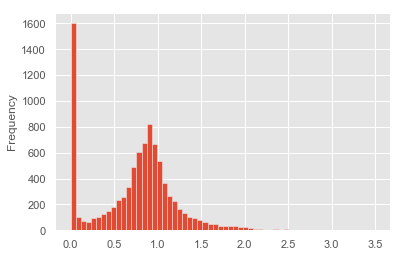

In [15]:
df_highest_rms_gmsq['gmsq'].plot.hist(bins=60)

# Galaxies above and below boundary line of contour plot

![](images/boundary_line.png)

In [16]:
N = 100

xcol,ycol = 'gsq', 'gmdsq'

# find abs max from whole data df, then create bin from 0 to absMax
max_abs_xcol_ycol = df[[xcol,ycol]].describe().iloc[[3,-1],:].abs().max().max()
bins = np.linspace(0, max_abs_xcol_ycol,N+1)
bins_dict = {i:v for i,v in enumerate(bins)}

# boundary line obtained from observing contour plot
x1y1x2y2 = [10,0,99,90]
x1,y1 = bins_dict[x1y1x2y2[0]], bins_dict[x1y1x2y2[1]]
x2,y2 = bins_dict[x1y1x2y2[2]], bins_dict[x1y1x2y2[3]]


df['above'] = df.eval(" ( (@x2-@x1) * gmdsq )  >= ( (@y2-@y1) * (gsq - @x1 )) ")

In [17]:
df_above = df[df.above==True].copy()
df_below = df[df.above==False].copy()

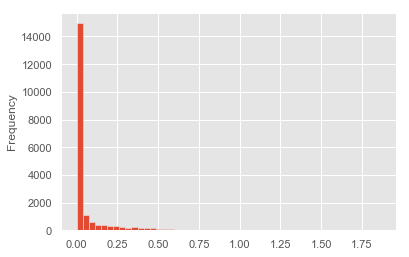

In [18]:
df_above['gmsq'].plot.hist(bins=50)

# Redo rms gsmq calculation for df_above

In [19]:
df_above['mmagnitude_bin'] = pd.cut(df_above['mmagnitude'],10)
df_above['mmagnitude_bin_number'] = pd.cut(df_above['mmagnitude'],10,labels=range(10))

df_above_bins = df_above.groupby('mmagnitude_bin').agg({'gmsq': ['sum', 'size'] }).reset_index()

df_above_bins.columns = ['mmagnitude_bin', 'gmsq_sum', 'ngals']


df_above_bins['rms_gmsq'] = (df_above_bins['gmsq_sum'] / df_above_bins['ngals'] ) **0.5
df_above_bins.style.background_gradient(subset=['rms_gmsq'])

,mmagnitude_bin,gmsq_sum,ngals,rms_gmsq
0,"(-15.171, -14.536]",8.07864,402,0.141761
1,"(-14.536, -13.908]",28.9434,1068,0.164622
2,"(-13.908, -13.28]",76.383,3267,0.152906
3,"(-13.28, -12.651]",77.5102,2960,0.16182
4,"(-12.651, -12.023]",109.515,2149,0.225745
5,"(-12.023, -11.395]",203.406,2396,0.291366
6,"(-11.395, -10.767]",299.672,2811,0.326507
7,"(-10.767, -10.138]",219.627,2120,0.321866
8,"(-10.138, -9.51]",86.4315,1609,0.23177
9,"(-9.51, -8.882]",35.152,802,0.209357


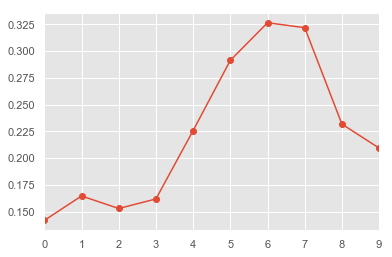

In [20]:
df_above_bins['rms_gmsq'].plot(style='-o')

In [21]:
ser = df_above_bins['rms_gmsq'].copy()

for i,v in ser.iteritems():
    print(i,v)

0 0.1417608198025623
1 0.16462247443596373
2 0.15290571848873555
3 0.16182049138868995
4 0.22574525278859023
5 0.29136607035531575
6 0.3265071280376181
7 0.3218660414873488
8 0.23177046597524908
9 0.20935703459232455


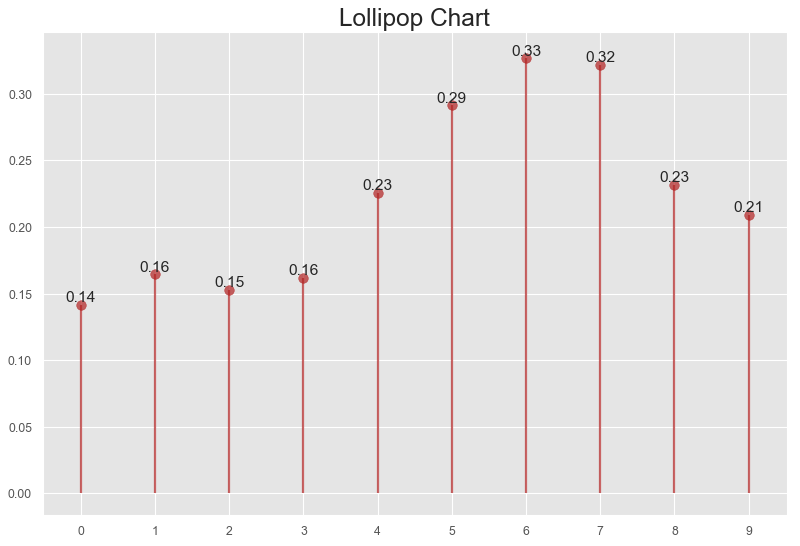

In [26]:
def lollipop_plot(ser,ofile=None):
    x = ser.index.to_numpy()
    y = ser.to_numpy()
    # Draw plot
    fig, ax = plt.subplots(figsize=(12,8), dpi= 80)
    ax.vlines(x=x, ymin=0, ymax=y, color='firebrick', alpha=0.7, linewidth=2)
    ax.scatter(x=x, y=y, s=75, color='firebrick', alpha=0.7)

    # Title, Label, Ticks and Ylim
    ax.set_title('Lollipop Chart', fontdict={'size':22})
    ax.set_ylabel('')
    ax.set_xticks(x)

    # Annotate
    for i,v in zip(x,y):
        ax.text(i, v, s= round(v,2), ha='center', va='bottom', fontsize=14)
        
    if ofile:
        plt.savefig(ofile,dpi=300)

    plt.show()
    
lollipop_plot(df_above_bins['rms_gmsq'],'images/lollipop_cleancat20.png')

In [23]:
df_above_bins.loc[0,'ngals']

402

# Histograms of magnitude bins

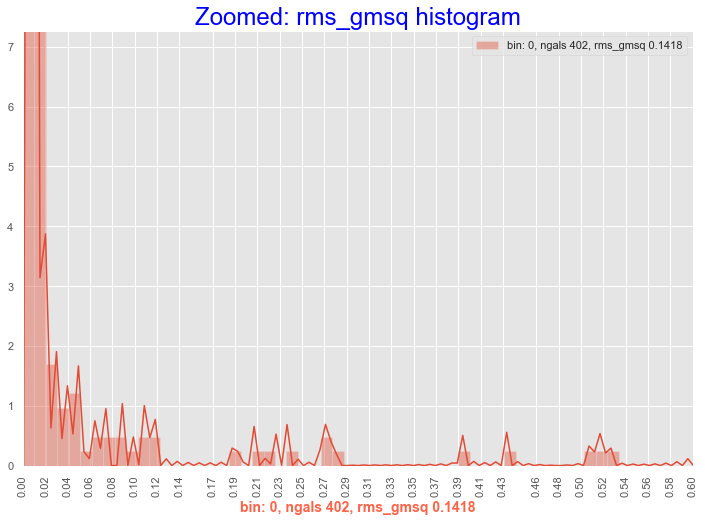

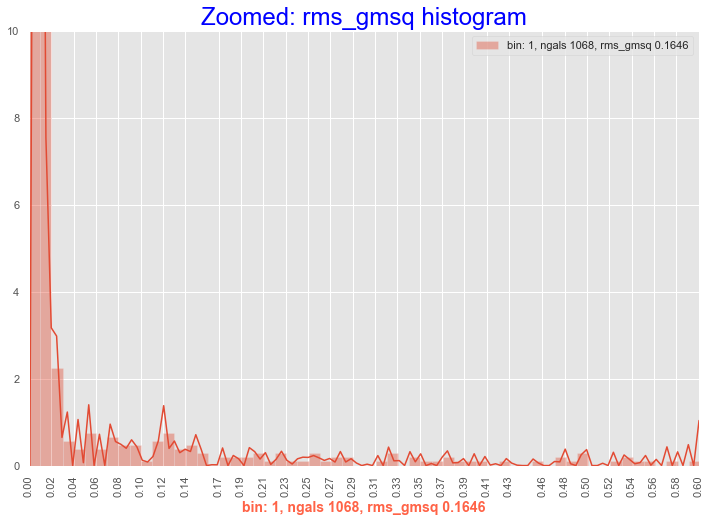

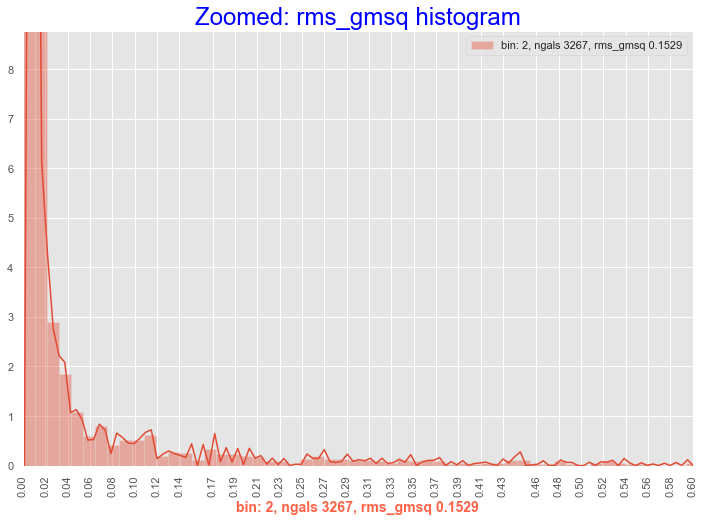

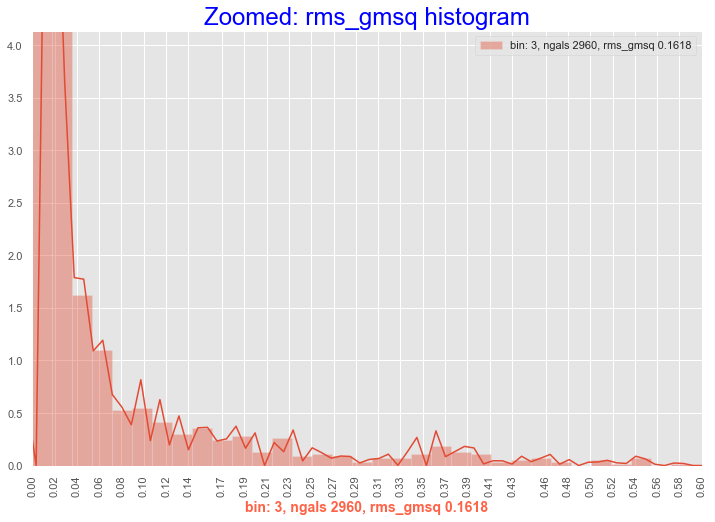

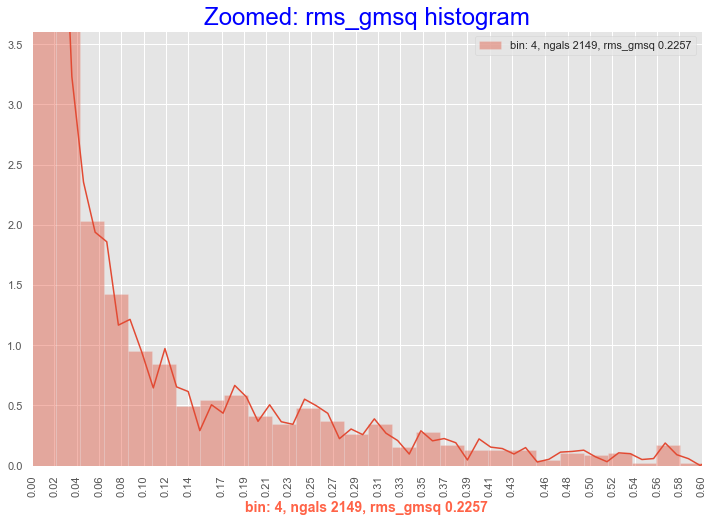

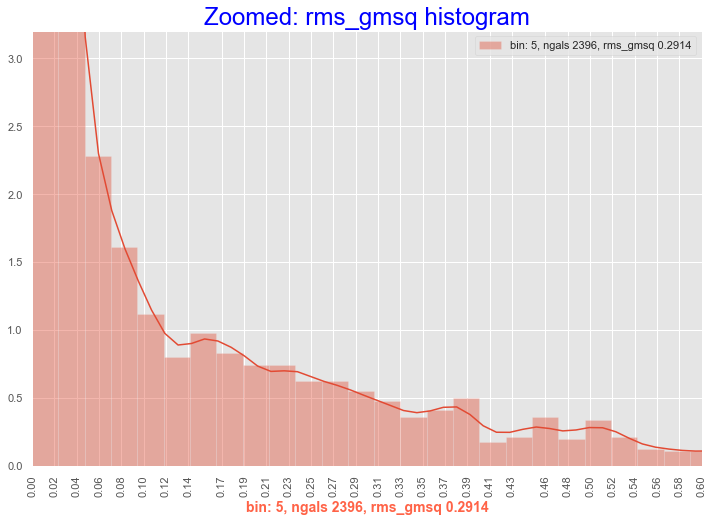

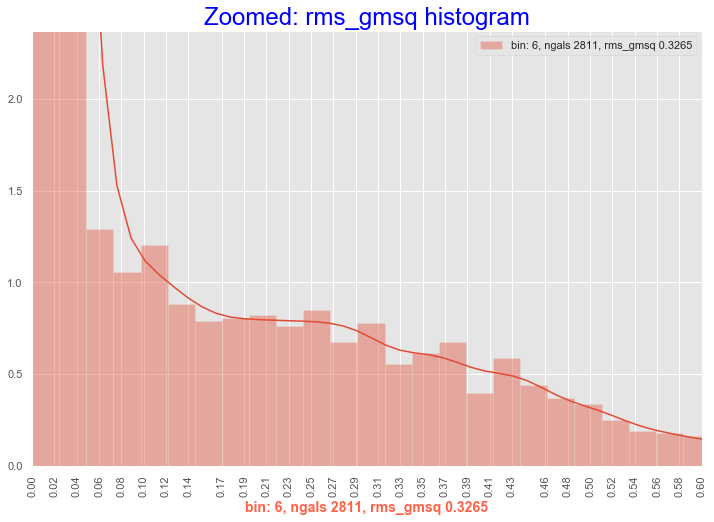

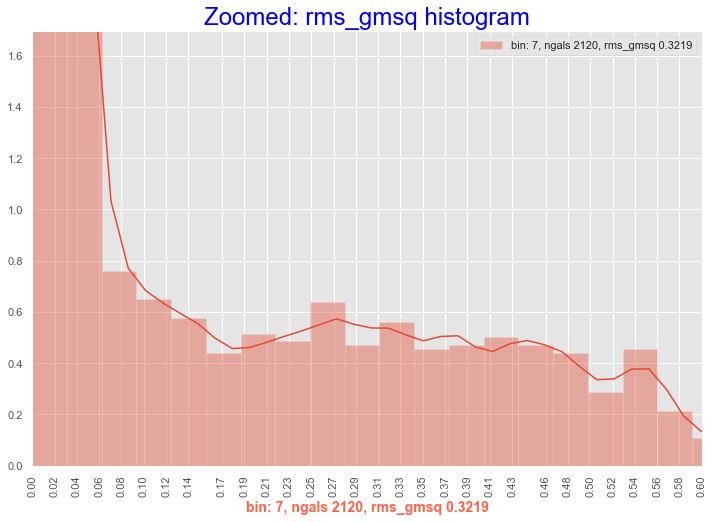

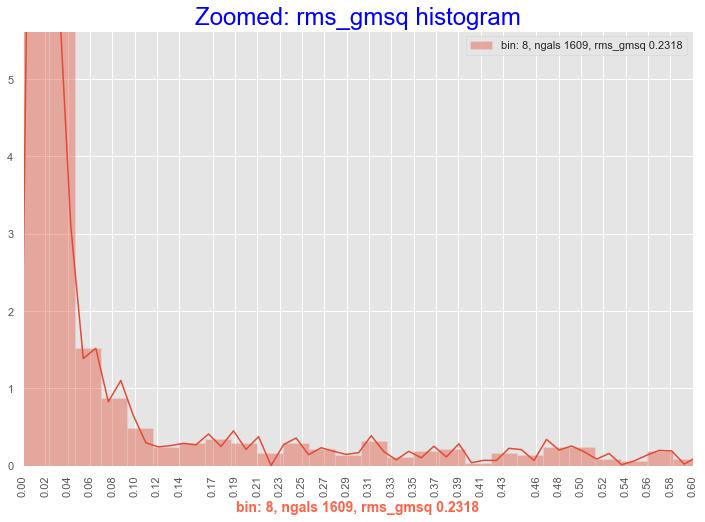

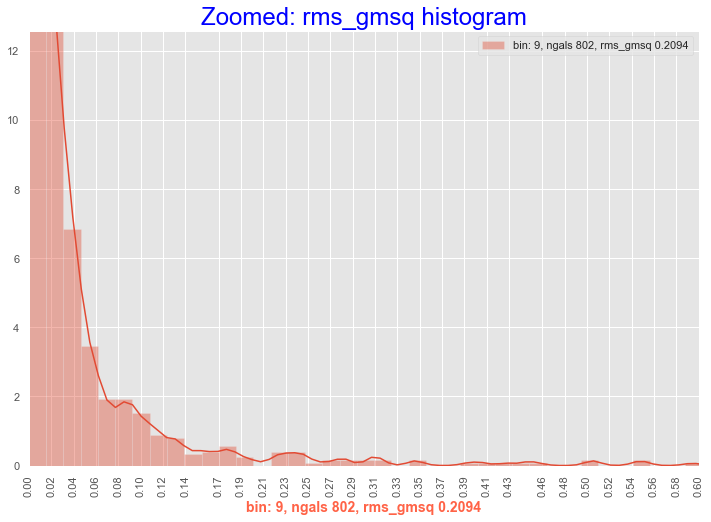

In [42]:
for i in range(10):
    dx = df_above[df_above['mmagnitude_bin_number'] == i ]
    ngals = df_above_bins.loc[i,'ngals']
    rms_gmsq = df_above_bins.loc[i,'rms_gmsq']
    
    label = f'bin: {i}, ngals {ngals}, rms_gmsq {rms_gmsq:.4f}'
    
#     ax = dx['gmsq'].plot.hist(bins=60,figsize=(12,8),label=label)

    plt.figure(figsize=(12,8))
    ax = sns.distplot(dx['gmsq'],bins=60,label=label)
    
    p1 = ax.patches[1].get_height()
    plt.ylim(0,p1)
    plt.title('Zoomed: rms_gmsq histogram',color='blue',fontsize=24)
    
    plt.xlabel(label,weight='bold',fontsize=14,color='tomato')
    plt.xlim(0,0.6)
    plt.xticks(np.linspace(0,0.6,30).round(2),rotation=90)
    
    plt.legend(loc=1)
    plt.show()
    plt.close()

# Scatter plot of x vs y of magnitude bins

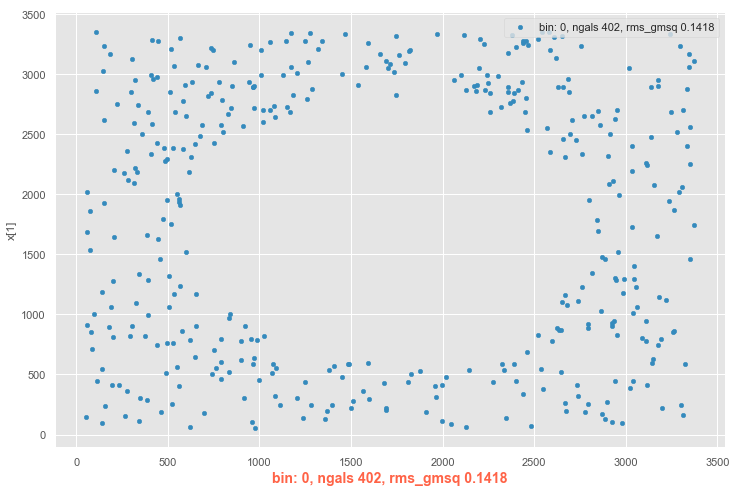

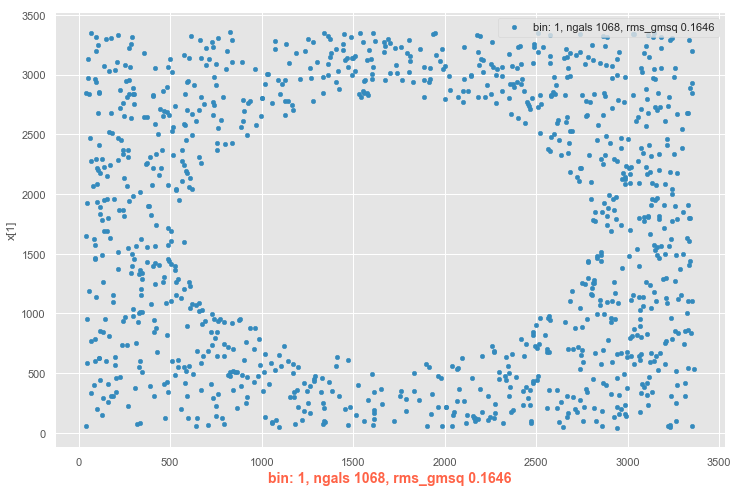

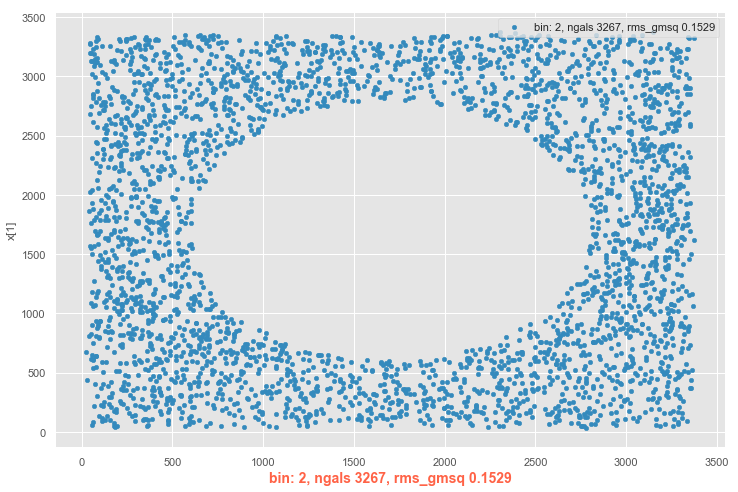

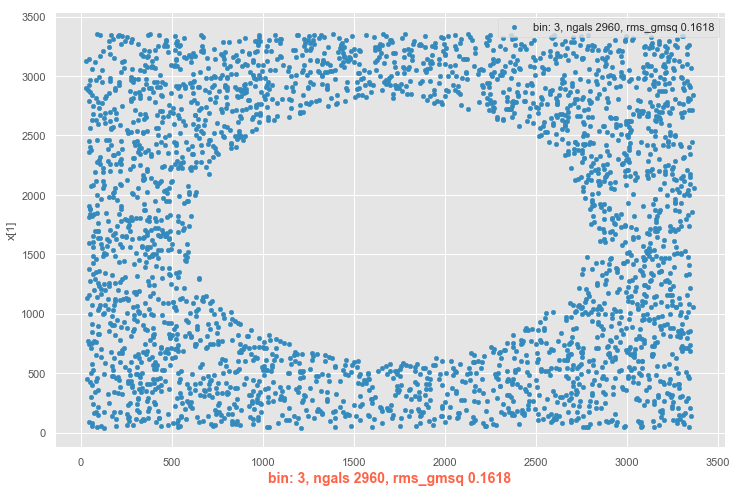

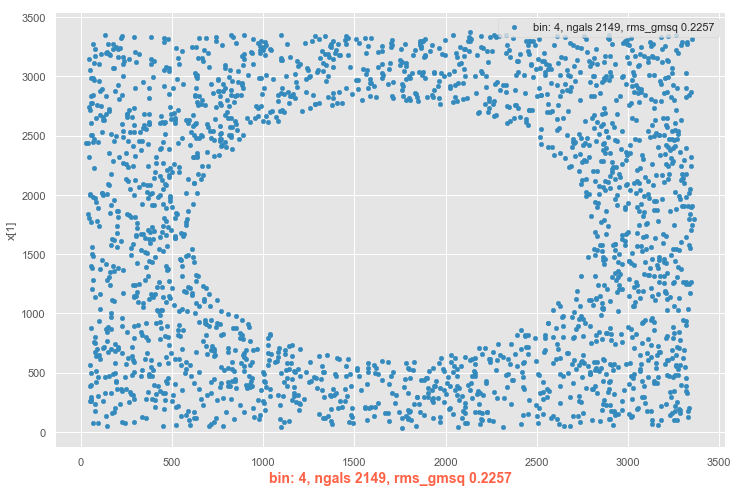

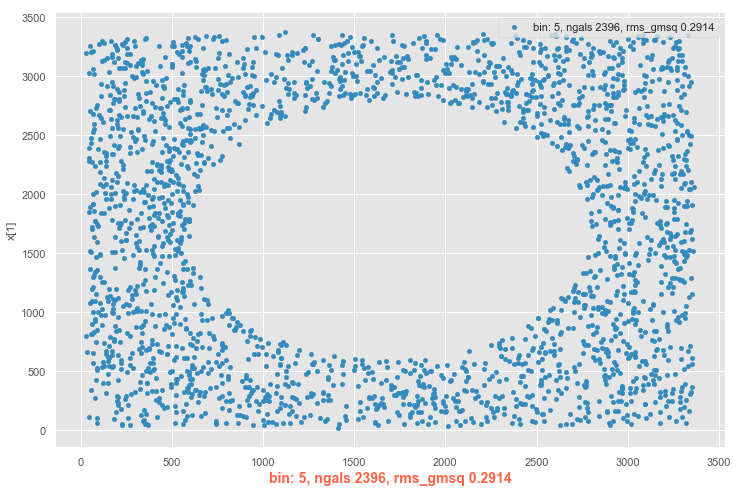

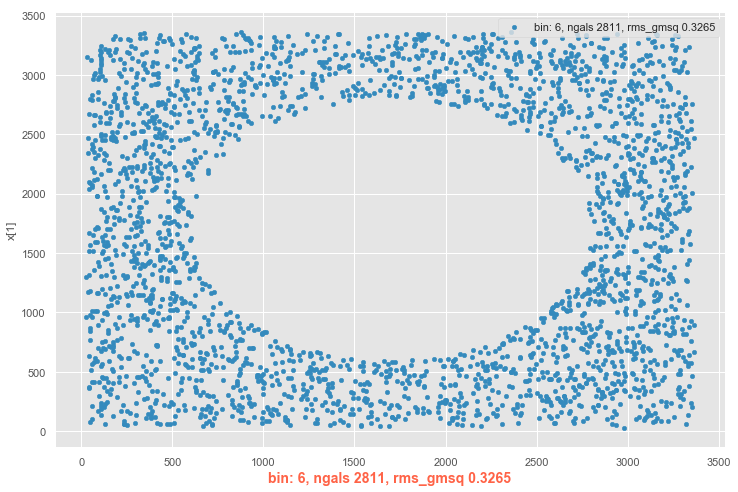

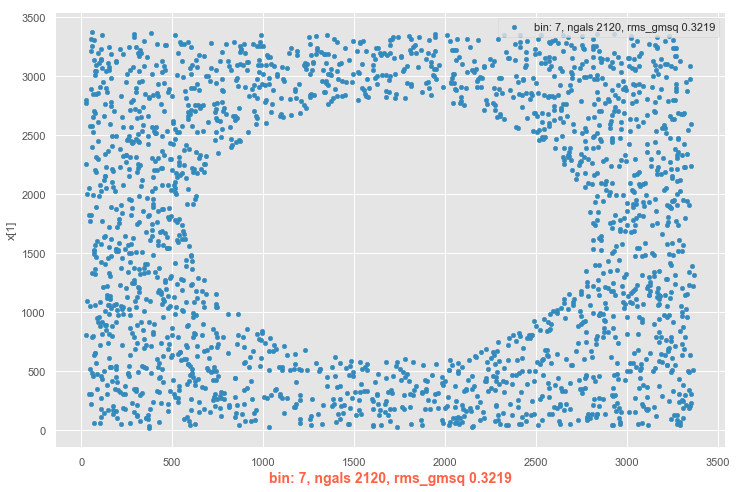

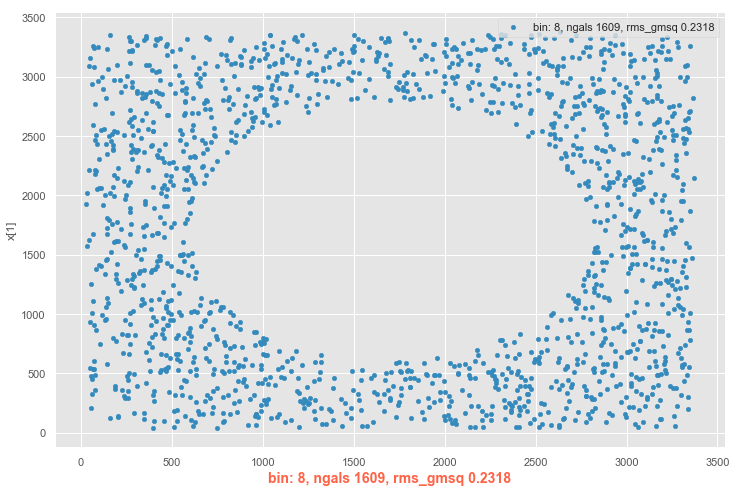

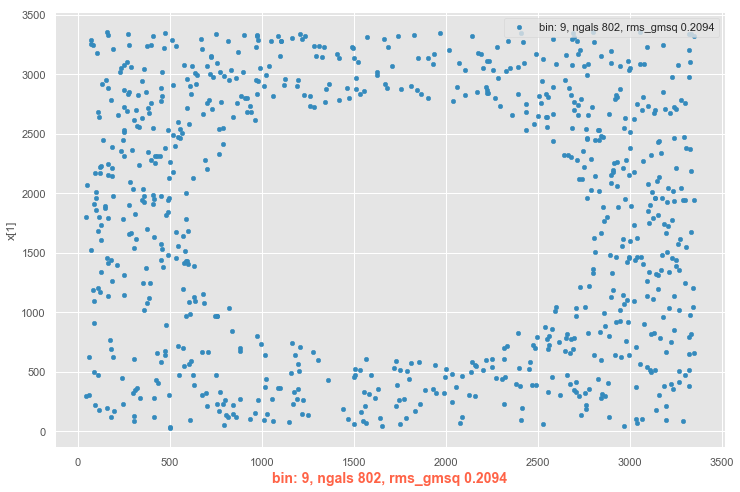

In [25]:
for i in range(10):
    dx = df_above[df_above['mmagnitude_bin_number'] == i ]
    ngals = df_above_bins.loc[i,'ngals']
    rms_gmsq = df_above_bins.loc[i,'rms_gmsq']
    
    label = f'bin: {i}, ngals {ngals}, rms_gmsq {rms_gmsq:.4f}'
    
    dx.plot.scatter(x='x[0]', y='x[1]', figsize=(12,8),label=label)
    plt.xlabel(label,weight='bold',fontsize=14,color='tomato')
    plt.legend(loc=1)
    plt.show()
    plt.close()